# Text Classification with sklearn

We will now return to sklearn classification models to classify text. We will use Yelp Reviews of restaurants to classify the reviews as 1, 3, or 5 stars. Note that the workflow for text classification is quite similar to the workflow we introduced in Intro to Machine Learning. It involves loading the data, cleaning and preprocessing, feature extraction (vectorization), training, and evaluation. Here, we will demonstrate the process using the random forest classifier, but other classification models can also be used. We will work without pipelines first and then review how to combine steps into a model pipeline.

### Imports, functions, files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
pd.set_option('display.max_colwidth',300)

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [4]:
# Load in the data using your path
df = pd.read_csv("Data/yelp-reviews-CA-2015-2018.csv.gz", index_col='review_id')
df.head()

,business_id,date,text,stars,language
review_id,,,,,
8W3g9ykr8aGGZMMdVbNPKA,gGaF0TtGRx1QOFe0EzuZLg,2015-01-01 00:01:02,"Lynn and Montecito flowers are simply the best. Awesome choices, friendly service and great pricing.",5,en
q10HcbeBRtcvsN7WC02fFw,2CqQ3Tnvj7h0rw84WEEjMw,2015-01-01 00:15:12,"Love this place! Always loved the food as they truly due have Killer BBQ. From pulled pork sandwiches to tri-tip the food is always a win. Now with the new location with the huge dog friendly patio, I think I just found my new favorite spot to watch a game, have a beer or a great meal. Looking f...",5,en
dXOY5UqXhcCQ6f9S-kRc2w,lOa1BVmTcbPpu05h3OPAQA,2015-01-01 00:19:36,"We stayed here last weekend with our dog. Its a motel style but the inside is a four star hotel. No kidding! The fireplace adds a nice touch. One block from the beach. Front desk is really nice. Could not ask for a better location. Of course this is no sheraton meaning there's no lobby, no fancy...",5,en
8mWVoTXecEkRXTvPONYFuw,QFh-h_OZ5Io-mBk32HN28A,2015-01-01 00:20:23,Came here for a quick bite and got the thai salad and a bowl of white bean chicken soup. The salad was pretty basic and the soup was lukewarm. We went around noon and most of the tables had dirty dishes from the previous customers. I asked one of the servers if he can clear one of the table for...,2,en
Xr5KEchLr-jvQiAZm1mtNA,cAbdvzqtFLaAAMFIyPf2AA,2015-01-01 00:47:19,"Finally was able to try lunch at Holdren's. My husband ordered the Kobe Burger (medium), and I ordered the Pastrami Melt/Caesar salad. The $18 Kobe Burger came to the table overcooked (well), and very dry. Fries weren't hot or crispy. On top of the open-faced Kobe burger: slice of tomato, car...",2,en


### Preparing the data

See which languages are represented.

In [5]:
# Obtain languages
df['language'].value_counts(dropna=False)

en       150025
es           79
de           72
pt           62
fr           41
it           17
sv           15
zh-cn        14
ja           12
da           10
nl            5
no            5
af            5
id            2
ca            2
tl            2
ko            2
vi            1
zh-tw         1
ro            1
hu            1
Name: language, dtype: int64

Limit our reviews to English.

In [6]:
# Remove any non-english reivews
df = df.loc[ df['language']=='en'].copy()
len(df)

150025

The dataset contains over 150,000 reviews. To reduce computational requirements, we will randomly reduce this to a more manageable 20,000 entries.

In [7]:
# Reduce sample size for demonstration
df = df.sample(n=20_000, random_state=42)
len(df)

20000

**Define X and y**

Now, we will define our target. We want to classify reviews as 1, 3, or 5 stars. We will remove 2 and 4-star reviews.


In [8]:
# Limit data to only 1,3, or 5 star reviews
df = df[df['stars'].isin([1,3,5])]
# Get value couunts for stars column
val_counts = df['stars'].value_counts()
val_counts

5    11488
1     2455
3     1488
Name: stars, dtype: int64

In [9]:
# Define X and y
X = df['text']
y = df['stars']

In [10]:
# Checking class balance 
y.value_counts(normalize=True)

5    0.744475
1    0.159095
3    0.096429
Name: stars, dtype: float64

**Train Test Split**

We will train test split the data using the same code we learned in Intro to Machine Learning. Due to the imbalanced classes, we will resample our training data. Because of this, we will name our first version of the training data as X_train_full and y_train_full. Then, we will undersample to balance the classes. We will call these undersampled versions X_train and y_train.


In [11]:
# Train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)

**Check for class balance**

In [12]:
# Check class balance
y_train_full.value_counts(normalize=True)

5    0.741381
1    0.162966
3    0.095654
Name: stars, dtype: float64

We have many more 5-star reviews than 1 or 3-star reviews. We will balance the classes with the RandumUnderSampler.

You may recall using SMOTE to oversample data to address class imbalance in Intro to Machine Learning. You cannot use SMOTE with NLP data because it would make up non-sensical vectors. Instead, we will use the RandmUnderSampler to undersample the data to address class balance.


In [13]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)
X_train = X_train.flatten()
# Check for class balance
y_train.value_counts(normalize=True)

1    0.333333
3    0.333333
5    0.333333
Name: stars, dtype: float64

**Vectorization**

Next, we will vectorize the text. We will start with the CountVectorizer using the default settings. We will fit on the training data.

In [14]:
# instantiate a vectorizer
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

CountVectorizer()

Let's check the number of terms identified.

In [15]:
# How many words in the vocabulary?
len(count_vectorizer.vocabulary_)

14424

We will transform both the train and test data.

In [16]:
# Transform train and test data 
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Checking the shape of X_train_counts will tell us the number of data points and the number of words.

In [17]:
X_train_counts.shape

(3321, 14424)

As expected, our training data set is 3321 reviews, and our fitted vocabulary is 14424.

**Fit and Evaluate the Model**

Now that our data is in a vectorized numerical format, we can use familiar models for classification. We will start with a random forest model. We will use the same custom classification metric functions that we have used previously.


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1107
           3       1.00      1.00      1.00      1107
           5       1.00      1.00      1.00      1107

    accuracy                           1.00      3321
   macro avg       1.00      1.00      1.00      3321
weighted avg       1.00      1.00      1.00      3321



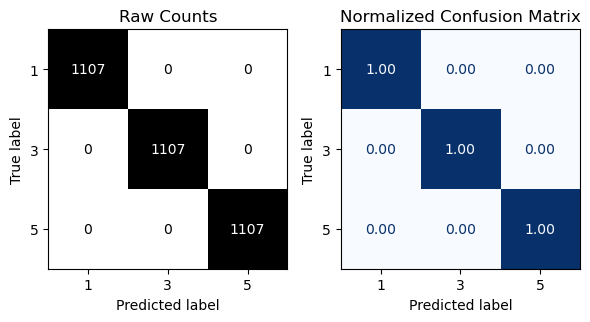


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.61      0.81      0.70       569
           3       0.36      0.65      0.47       381
           5       0.96      0.80      0.87      2908

    accuracy                           0.79      3858
   macro avg       0.65      0.75      0.68      3858
weighted avg       0.85      0.79      0.81      3858



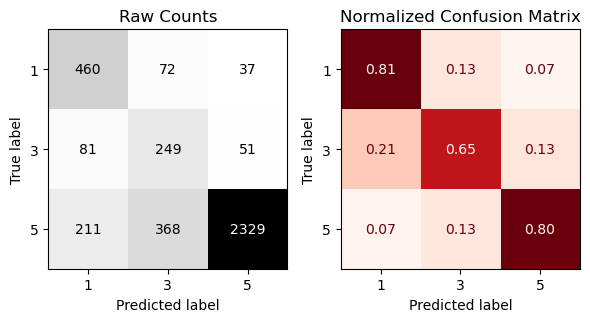

In [18]:
# Instantitate a Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_counts, y_train)
# Obtain evaluation metrics
evaluate_classification(clf, X_train_counts, y_train, X_test_counts, y_test)

This model is overfit, performing perfectly on the training data, but struggling on the test data with an overall accuracy of 79%.

Let's see which features the model used the most by obtaining the feature importances.

(Numbers will change)

<Axes: >

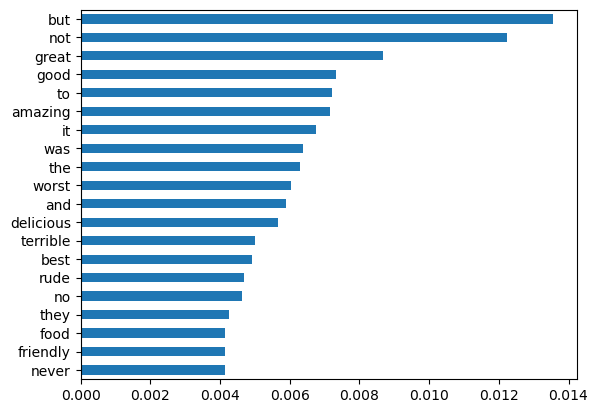

In [19]:
# Plot feature importances
importances = pd.Series(clf.feature_importances_, 
                       index =  count_vectorizer.get_feature_names_out())
importances.sort_values().tail(20).plot(kind='barh')

As we can see, we did not include stopword removal in our vectorizer, so many of our most important features are indeed stopwords.

We will try another model, but we will remove stopwords. Also, we will review how to use a model pipeline.

### Model Pipeline

We have previously used model pipelines using make_pipeline(), but we will use Pipeline() because it allows us to name each step ourselves, which can be helpful. For this model, we will include the stop_words = 'english' argument when instantiating the CountVectorizer.

In [20]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

Now, we will fit the model pipeline on the training data and call our custom function to evaluate it.

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1107
           3       1.00      1.00      1.00      1107
           5       1.00      1.00      1.00      1107

    accuracy                           1.00      3321
   macro avg       1.00      1.00      1.00      3321
weighted avg       1.00      1.00      1.00      3321



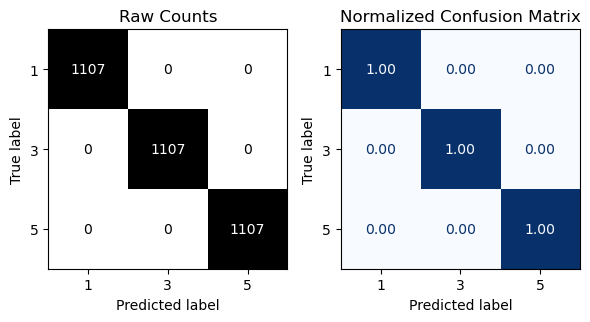


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.65      0.82      0.72       569
           3       0.39      0.60      0.47       381
           5       0.96      0.85      0.90      2908

    accuracy                           0.82      3858
   macro avg       0.67      0.75      0.70      3858
weighted avg       0.86      0.82      0.83      3858



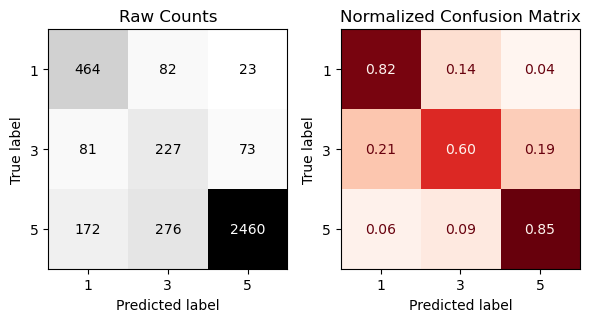

In [21]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

The model is still overfitting and performed similarly without the stopwords. Let's explore the important features when stopwords were excluded. Recall that we must designate which step of the pipeline when obtaining feature importances_. We used [-1] because the model is the last step of the pipeline.

<Axes: >

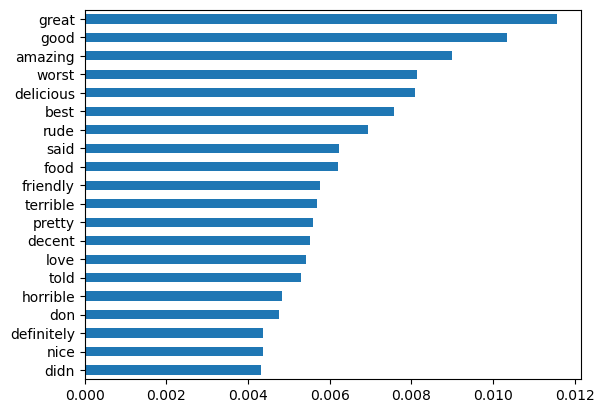

In [22]:
# Plot feature importances
importances = pd.Series(clf_pipe[-1].feature_importances_, 
                       index =  clf_pipe[0].get_feature_names_out())
importances.sort_values().tail(20).plot(kind='barh')

Many of the "non-stopwords" that were important to the model have clear positive meanings such as "good," delicious," or 'amazing" or clear negative meanings such as "worst," "rude," "terrible," or "horrible."

### Summary

In this lesson, you fit your first model for text classification. While the preprocessing steps are specialized for text data, much of the modeling and evaluation is familiar from our earlier classification models. In upcoming lessons, you will learn how to tune your models using grid search.
